In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from Adam import Adam
from timeit import default_timer
import operator
from functools import reduce
from functools import partial
from fourier import FNO1d
from normal import UnitGaussianNormalizer
from utilities3 import LpLoss

In [2]:
# Load Data
x = np.loadtxt("x.dat", dtype=np.float32)
y = np.loadtxt("y.dat", dtype=np.float32)
x = x.reshape(x.shape[0], x.shape[1] // 2, 2)

In [3]:
# Parameters
nt = 100
epochs =1000
ntrain = 900
ntest = 100
batch_size = 20
gamma = 0.5
learning_rate = 0.001
step_size= 50
modes=12
width=32

In [4]:
# Create train/test splits
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1)
x_train = torch.from_numpy(x_train).cuda()
y_train = torch.from_numpy(y_train).cuda()
x_test = torch.from_numpy(x_test).cuda()
y_test = torch.from_numpy(y_test).cuda()

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [5]:
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [6]:
model = FNO1d(modes, width, 2, 1).cuda()
print(count_params(model))

107009


In [7]:
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [8]:
loss = LpLoss()
train_lossArr = []
test_lossArr = []
time_Arr = []

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_loss = 0
    for x, y in trainData:
        x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        out = model(x)
        out = out.reshape((out.shape[0], out.shape[1]))        
        
        lp = loss(out.view(batch_size, -1), y.view(batch_size, -1))
        lp.backward()
        
        optimizer.step()
        train_loss += lp.item()
        
    scheduler.step()
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in testData:
            x, y = x.cuda(), y.cuda()
            
            out = model(x)
            out = out.reshape((out.shape[0], out.shape[1]))
            test_loss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
            
    train_loss /= len(trainData)
    test_loss /= len(testData)
    
    train_lossArr.append(train_loss)
    test_lossArr.append(test_loss)
    
    t2 = default_timer()
    time_Arr.append(t2-t1)
    if ep%50 == 0:
        print(ep, t2-t1, train_loss, test_loss)
print("Avg Epoch Time:", sum(time_Arr)/len(time_Arr))

0 0.8304020732175559 0.6706486105918884 0.4897963464260101
50 0.19864412699826062 0.04249485913250181 0.033922507613897326
100 0.19332271302118897 0.02115295665959517 0.017508316040039062
150 0.19413903914391994 0.011771153648280436 0.010612880624830724
200 0.19451930280774832 0.01167018370081981 0.009123593475669623
250 0.19401982403360307 0.007192556829088264 0.007536918856203556
300 0.1927044610492885 0.006028603069070312 0.007168855518102646
350 0.1923881561961025 0.0055865552742034195 0.006738896016031504
400 0.1945244618691504 0.00540149110990266 0.006649486534297466
450 0.19325960404239595 0.005287077645253804 0.00652924608439207
500 0.19553431100212038 0.0051966531978299224 0.006509928405284882
550 0.19329263595864177 0.005163366471727689 0.0064884604886174205
600 0.19409541692584753 0.005149588671823343 0.006485429685562849
650 0.19284128700383008 0.005136676344813572 0.006468204781413078
700 0.1924590989947319 0.005135061467687289 0.0064649531617760655
750 0.19221189594827592

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


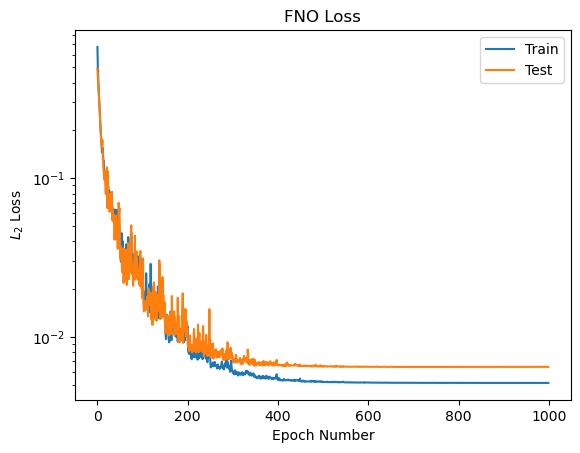

In [9]:
plt.plot(train_lossArr, label="Train")
plt.plot(test_lossArr, label="Test")
plt.yscale("log")
plt.xlabel("Epoch Number")
plt.ylabel(r"$L_2$ Loss")
plt.title("FNO Loss")
plt.legend()
plt.savefig("fnoLinearLoss.eps")

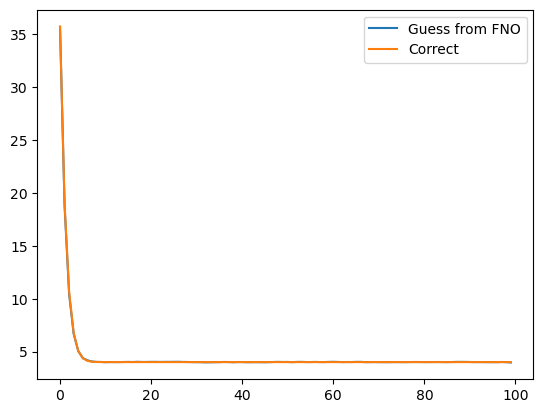

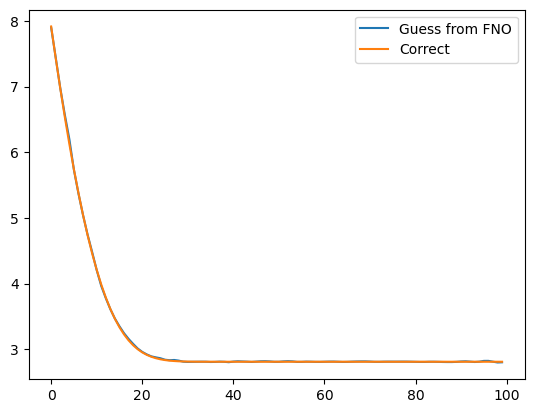

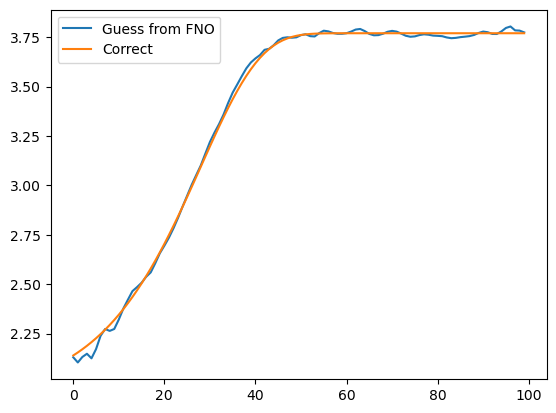

In [10]:
# Show some examples
with torch.no_grad():
    for x, y in testData:
        x, y = x.cuda(), y.cuda()   
        out = model(x, grid_repeated)
        
    for i in range(3):
        plt.figure()
        plt.plot(out[i].cpu().detach().numpy(), label=r"$\hat{\theta}$ from FNO")
        plt.plot(y[i].cpu().detach().numpy(), label=r"$\hat{\theta}$ from Original Estimator")
        plt.legend()

In [16]:
with torch.no_grad():
    out_theta = []
    guess_theta = []
    test_loss = 0
    loss_end = 0
    for x, y in testData:
        x, y = x.cuda(), y.cuda()
            
        out = model(x)
        out = out.reshape((out.shape[0], out.shape[1]))
        
        for i in range(len(y)):
            out_theta.append(y[i][-1].cpu().detach())
            guess_theta.append(out[i][-1].cpu().detach())
            loss_end += (out_theta[-1]-guess_theta[-1])**2
        
        test_loss += loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()
print("TEST MSE:", test_loss/len(testData))
print("TEST MSE FINAL VALUE:", loss_end.item()/len(testData))

TEST MSE: 0.006475165020674467
TEST MSE FINAL VALUE: 0.01678529381752014


Text(0, 0.5, 'Final $\\hat{\\theta}$ from FNO')

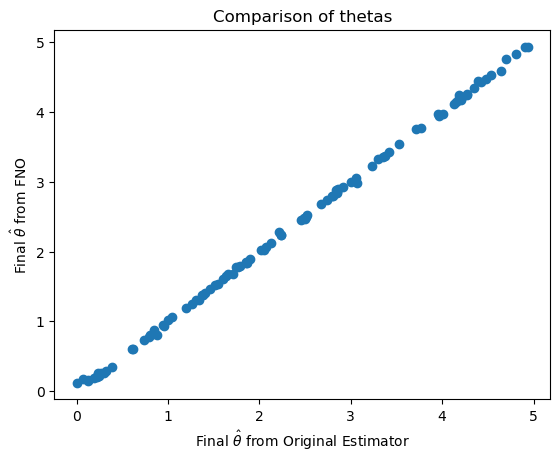

In [14]:
plt.title("Comparison of thetas")
plt.scatter(out_theta, guess_theta)
plt.xlabel(r"Final $\hat{\theta}$ from Original Estimator")
plt.ylabel(r"Final $\hat{\theta}$ from FNO")

In [15]:
# Save Model
torch.save(model.state_dict(), "fnoModel1")